## Binary Loans Example

The goal of this example, based on [an existing scikit-learn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html), is to showcase various baseline models and evaluation metrics for binary classification. The use-case we are dealing with is predicting the acceptance of candidates applying for a loan. The application can either be marked as good or bad, hence the binary nature of the task.

We start with loading the dataset from openML. Note that in real-life setting, we would probably have to join and aggregate multiple tables from multiple sources before landing a neat dataframe ready to use for ML. We would also need to worry about data quality, feature selection, missing values etc. It we wanted to deploy this model into some production system, the availability of our features at the prediction time must also be checked.

Note that we also don't perform exploration data analysis here, although understanding the data we're playing with is of paramount importance.

In [1]:
import sklearn
from sklearn.datasets import fetch_openml

sklearn.set_config(transform_output="pandas")

german_credit = fetch_openml(data_id=31, as_frame=True, parser="pandas")
X, y = german_credit.data, german_credit.target
X

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,4,real estate,31,none,own,1,unskilled resident,1,none,yes
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,4,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,4,car,38,none,own,1,skilled,1,none,yes
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,4,no known property,23,none,for free,1,skilled,1,yes,yes


In [2]:
y.value_counts()

class
good    700
bad     300
Name: count, dtype: int64

We have very few points (1000) and there is a slight imbalance, but nothing preventing the learning task. We make sure to use a stratified strategy to split our data. Note that we only perform a single train test split here, but for sake of estimating confidence intervals, we could shuffle the dataset using multiple random seeds and loop through them.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

We then have to select our evaluation metrics. The FPR is not a default metric in scikit-learn so we define it here.

In [4]:
from sklearn.metrics import confusion_matrix

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

Our goal is to predict "bad" applications, hence our positive class is "bad", and the negative is "good". scikit-learn provide ways to specify it, but we could also have transformed our target directly to reflect this target design.

We also include proper scoring rules to the evaluation metrics (brier score and log loss), because optimizing these improves both the discriminative power (ranking) and the calibration (reliability) of our estimators. In a nutshell, proper scoring rules are minimized when the predicted distribution converges to the true probability distribution.

`make_scorer` is a utility function that enable us to optimize any loss function using scikit-learn cross validation objects. It can also be used as a standalone function the following way:

```python
make_scorer(model, X_test, y_test)
```

In [5]:
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    log_loss,
    brier_score_loss,
)
    
 # Our target is to predict whether or not a credit is bad.
pos_label, neg_label = "bad", "good"
tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
    "log_loss": make_scorer(log_loss, labels=[pos_label, neg_label], response_method="predict_proba"),
    "brier_score_loss": make_scorer(brier_score_loss, pos_label=pos_label, response_method="predict_proba"),
}

We then add our utility function "cost gain". Unlike the previous metrics which are generic to the binary classification setting, this utility function is specific to the problem at hand and must be carefuly considered.

Here, we set this utility function using a cost matrix, which indicates how much error costs, and how much correct predictions yield. This is where a strong intuition of the use-case is needed. We considered the coefficients to be fixed, but note that we could also pass variables from our dataframe (e.g. a False positive could be proportional to the amount of the loan).

In this example, correct classifications yield 0, false negatives yield -5 and false positives yield -1. We can already understand that penalizing false negatives 5x time more than false positives will put the classification threshold closer to 0 than to 0.5.

In [6]:
import numpy as np

def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


scoring["cost_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label
)

The following is small helper to evaluate models with our metrics and storing results into a dictionnary.

In [7]:
def make_results(model, X_test, y_test, threshold):
    results_ = {
        "y_proba": model.predict_proba(X_test),
        "model": model,
        "threshold": threshold,
        "params": model.get_params(),
    }
    for scoring_name, scoring_func in scoring.items():
        results_[scoring_name] = scoring_func(model, X_test, y_test)

    return results_

results = dict()

As a sanity check, we build two dummy classifiers:
- The first one always predict that a loan is "bad" (i.e. the label is always positive)
- The second one always predict that a loan is "good" (i.e. the label is always negative)

If our final estimator fails to beat these baselines, our modeling strategy has a serious issue.

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict

pos_model = DummyClassifier(
    strategy="constant", constant=pos_label
).fit(X_train, y_train)

neg_model = DummyClassifier(
    strategy="constant", constant=neg_label
).fit(X_train, y_train)

results["always_reject"] = make_results(pos_model, X_test, y_test, threshold=.5)
results["always_accept"] = make_results(neg_model, X_test, y_test, threshold=.5)

/Users/vincentmaladiere/miniforge3/envs/sandbox/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
neg_model.classes_

array(['bad', 'good'], dtype=object)

Let's also adds an oracle classifier, e.g. an estimator that perfectly predict each class, with the best probability. This will be a helpful upper bound.

In [10]:
from sklearn.base import ClassifierMixin, BaseEstimator

class OracleClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, pos_label):
        self.pos_label = pos_label
    
    def fit(self, X, y_test):
        self.y_test = y_test
        self.classes_ = y_test.unique()
        return self

    def predict(self, X):
        return self.y_test
    
    def predict_proba(self, X):
        y_proba = self.y_test == self.pos_label
        return np.array([y_proba, 1 - y_proba]).T


oracle = OracleClassifier(pos_label).fit(None, y_test)
results["oracle"] = make_results(oracle, X_test, y_test, threshold=.5)

We then fit a gradient boosting classifier on the dataset directly, using the log loss by default. Note that since the categorical columns of the dataframe are encoded as "category", the `HistGradientBoostingClassifier` can handle them natively without any preprocessing.

We also tune some hyperparameters on the log loss using a `HalvingRandomSearchCV`, which is supposed to converge faster to a good hyper parameter combination than the regular `RandomizedSearchCV` with less computing resources.

We let the classification threshold as default for now (0.5), but we will tune it later.

In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

hgbt_model = HistGradientBoostingClassifier(
    categorical_features="from_dtype", random_state=0
)
param_grid = dict(
    learning_rate=[0.05, 0.1, 0.2],
    max_depth=[2, 5, 10],
    min_samples_leaf=[1, 5, 10, 20],
)
hgbt_search = HalvingRandomSearchCV(
    hgbt_model,
    param_grid,
    resource="max_iter",
    max_resources=250,
    min_resources=50,
    scoring=scoring["log_loss"],
    cv=StratifiedKFold(),
).fit(X_train, y_train)
# y_proba_hgbt = cross_val_predict(hgbt_model, X_train, y_train, method="predict_proba")

In [12]:
results["vanilla_hgbt"] = make_results(
    hgbt_search.best_estimator_,
    X_test,
    y_test,
    threshold=.5,
)
results["vanilla_hgbt"]["y_proba"][:5]

array([[0.86843301, 0.13156699],
       [0.00102281, 0.99897719],
       [0.00654143, 0.99345857],
       [0.24936461, 0.75063539],
       [0.97827873, 0.02172127]])

Next, we fit a logistic regression. On a small dataset, we can actually expect this linear model to beat the boosting trees w.r.t the proper scoring rule and the utility functions.

The LogisticRegression estimator doesn't handle categorical variables natively. To perform preprocessing easily, we use the TableVectorizer from skrub. The TableVectorizer acts a preprocessor that use different encoders according to the data type and the cardinality of categorical variables.

Here, since the cardinality of all categorical columns is lower than 30, it will apply one hot encoding to all of them (which is preferable over ordinal encoding with linear models).

In [13]:
import warnings
from skrub import TableVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

lr = make_pipeline(
    TableVectorizer(numerical_transformer=StandardScaler()),
    LogisticRegression()
)

param_grid = {
    'logisticregression__C': np.logspace(0.0001, 1, 10),
}

with warnings.catch_warnings(action="ignore"):
    lr_search = HalvingRandomSearchCV(
        lr,
        param_grid,
        scoring=scoring["log_loss"],
        cv=StratifiedKFold(),
    ).fit(X_train, y_train)

In [14]:
results["vanilla_lr"] = make_results(
    lr_search.best_estimator_,
    X_test,
    y_test,
    threshold=.5,
)
results["vanilla_lr"]["y_proba"][:5]

array([[0.28255933, 0.71744067],
       [0.09392255, 0.90607745],
       [0.26270784, 0.73729216],
       [0.39312519, 0.60687481],
       [0.44570603, 0.55429397]])

We now define some plotting functions.

In [15]:
import json
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import TunedThresholdClassifierCV


def _get_palette(names):
    return dict(
        zip(
            names,
            sns.color_palette('colorblind', n_colors=len(names))
        )
    )


def plot_results(results):
    plot_gains(results)
    plot_gains_curve(results)
    plot_roc_curve(results)
    plot_pr_curve(results)
    plot_calibration_curve(results)
    plot_hist_proba(results)
    plot_model_html(results)
    

def plot_metric(results, metric_name):
    
    values = []
    for named_results in results.values():
        values.append(named_results[metric_name])
    
    names = list(results)
    palette = _get_palette(names)
    
    fig, ax = plt.subplots()
    ax = sns.barplot(y=names, x=values, hue=names, palette=palette.values(), orient="h")
    ax.set_title(metric_name)


def plot_gains_curve(results):

    tuned_models = {
        name: named_results["model"] for name, named_results in results.items()
        if isinstance(named_results["model"], TunedThresholdClassifierCV)
        and named_results["model"].store_cv_results
    }
    if len(tuned_models) == 0:
        return
    
    names = list(results)
    palette = _get_palette(names)
    
    fig, ax = plt.subplots()

    for name, model in tuned_models.items():
        ax.plot(
            model.cv_results_["thresholds"],
            model.cv_results_["scores"],
            color=palette[name],
        )
        ax.plot(
            model.best_threshold_,
            model.best_score_,
            "o",
            markersize=10,
            color=palette[name],
            label=f"Optimal cut-off point for the business metric of {name}",
        )
        ax.legend()
        ax.set_xlabel("Decision threshold (probability)")
        ax.set_ylabel("Objective score (using cost-matrix)")
        ax.set_title("Objective score as a function of the decision threshold")


def plot_roc_curve(results):    
    
    names = list(results)
    palette = _get_palette(names)
    
    fig, ax = plt.subplots()
    for idx, (name, named_results) in enumerate(results.items()):

        y_proba = named_results["y_proba"][:, 0]
        model = named_results["model"]

        ax.plot(
            named_results["fpr"],
            named_results["recall"],
            marker="o",
            color=palette[name],
            markersize=10,
            label=f"Cut-off point for {named_results['threshold']:.3f}",
        )

        is_last_plot = idx == len(results) - 1
        
        RocCurveDisplay.from_predictions(
            y_test,
            y_proba,
            pos_label=pos_label,
            plot_chance_level=is_last_plot, # display on top
            name=name,
            color=palette[name],
            ax=ax
        )

        ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def plot_pr_curve(results):

    names = list(results)
    palette = _get_palette(names)
    
    fig, ax = plt.subplots()
    for idx, (name, named_results) in enumerate(results.items()):

        y_proba = named_results["y_proba"][:, 0]
        model = named_results["model"]

        is_last_plot = idx == len(results) - 1

        ax.plot(
            named_results["recall"],
            named_results["precision"],
            marker="o",
            color=palette[name],
            markersize=10,
            label=f"Cut-off point for {named_results['threshold']:.3f}",
        )
        PrecisionRecallDisplay.from_predictions(
            y_test,
            y_proba,
            pos_label=pos_label,
            plot_chance_level=is_last_plot, # display on top
            name=name,
            color=palette[name],
            ax=ax
        )
        ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    plt.show()


def plot_calibration_curve(results):

    names = list(results)
    palette = _get_palette(names)
    
    fig, ax = plt.subplots()
    for name, named_results in results.items():

        y_proba = named_results["y_proba"][:, 0]
        
        CalibrationDisplay.from_predictions(
            y_test,
            y_proba,
            n_bins=10,
            pos_label=pos_label,
            name=name,
            ax=ax
        )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def plot_hist_proba(results):

    names = list(results)
    palette = _get_palette(names)
    
    fig, axes = plt.subplots(figsize=(4, 12), nrows=len(results))
    axes = axes.flatten()
    for ax, (name, named_results) in zip(axes, results.items()):
        y_proba = named_results["y_proba"][:, 0]
        sns.histplot(
            y_proba,
            color=palette[name],
            bins=10,
            ax=ax,
        )
        ax.set_title(name)
        ax.set_xlabel("Mean predicted probability")
        ax.set_xlim([0, 1.1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_model_html(results):
    for name, named_results in results.items():
        print(name)
        display(named_results["model"])

First and foremost, let's compare our proper scoring rules across models.

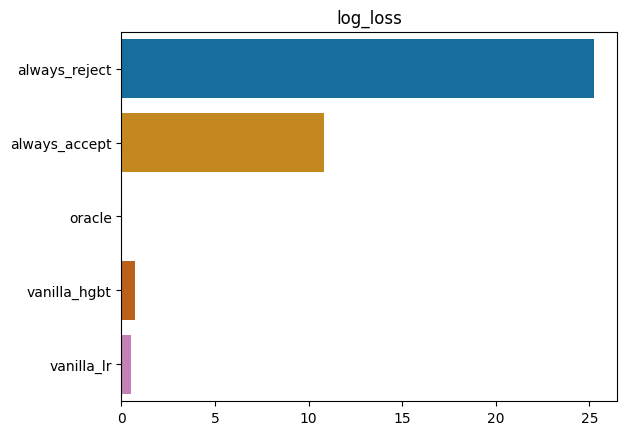

In [16]:
plot_metric(results, metric_name="log_loss")

As we trained our models on the log loss, we can expect them to perform particularly well on this evaluation metric. Both models beat the baselines by a huge margin.

Let's now continue our evaluation using a different proper scoring rule, the brier score.

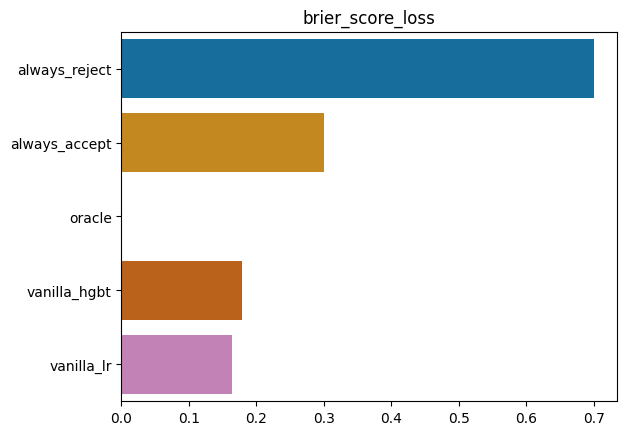

In [17]:
plot_metric(results, metric_name="brier_score_loss")

Interestingly, both models still perform significantly better than the baselines, but the gap has narrowed. The logistic regression is slightly better than the boosting tree here.

Last but not least, let's compare models w.r.t our utility function.

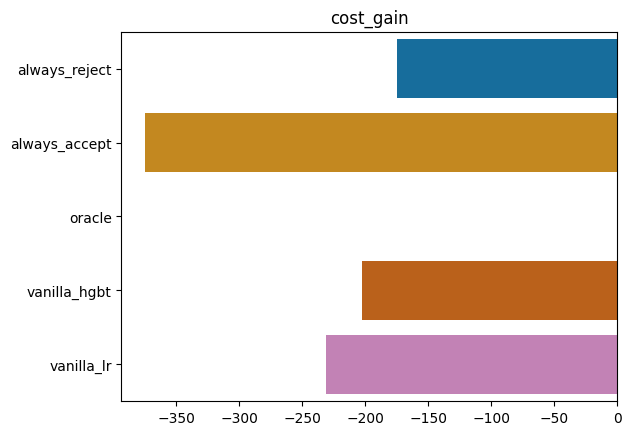

In [18]:
plot_metric(results, metric_name="cost_gain")

This time, our dummy model "always reject" perform better on the end task than any of the two ML models. This is concerning, as it would mean that deploying this model would yield better gain than our ML solution.

These metrics were obtained using the vanilla classification threshold of 0.5 for our ML models, which is not adapted to our end task here. We should now tune this threshold to improve our yield.

Let's tune the decision threshold with a nested CV, optimizing the utility function.

In [19]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_hgbt = TunedThresholdClassifierCV(
    hgbt_search,
    scoring=scoring["cost_gain"],
    store_cv_results=True,
).fit(X_train, y_train)

In [20]:
results["tuned_hgbt"] = make_results(
    tuned_hgbt,
    X_test,
    y_test,
    threshold=tuned_hgbt.best_threshold_,
)

In [21]:
with warnings.catch_warnings(action="ignore"):
    tuned_lr = TunedThresholdClassifierCV(
        lr_search,
        scoring=scoring["cost_gain"],
        store_cv_results=True,
    ).fit(X_train, y_train)

In [22]:
results["tuned_lr"] = make_results(
    tuned_lr,
    X_test,
    y_test,
    threshold=tuned_lr.best_threshold_,
)

Let's observe the gains one more time.

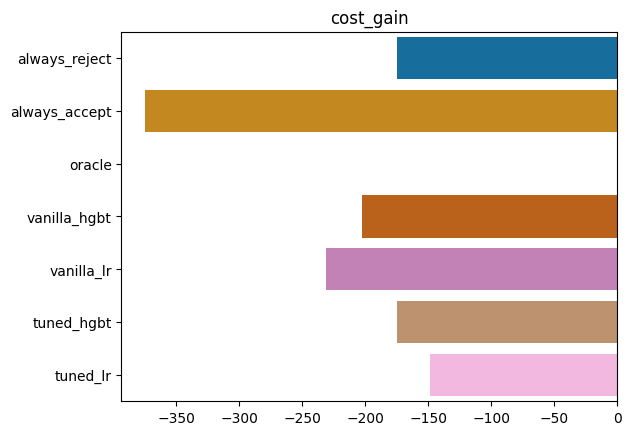

In [23]:
plot_metric(results, metric_name="cost_gain")

We successfully have found a threshold that outperforms the naive baselines for both models. The trees slightly beats the logistic regression. We observe below the gain curve for the tuned models on the training test (the previous plot were made using the test set).

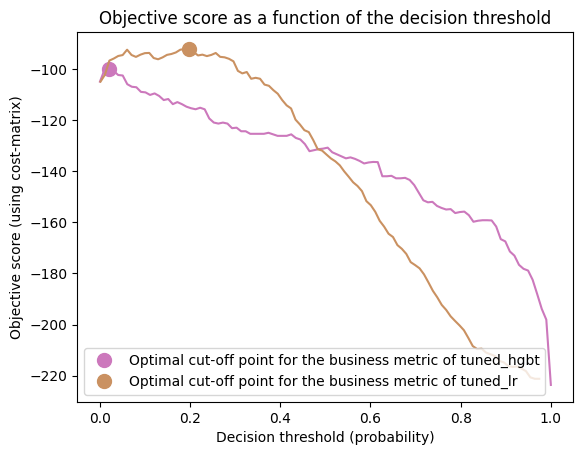

In [65]:
plot_gains_curve(results)

As expected, both optimal decision threshold are fairly low. Interestingly, the logistic regression had better performances than the gradient boosting trees on the training set.

In some applications, the utility function is intricate to estimate and more generic figures like the ROC curve could be crucial in terms of decision making for modeling.

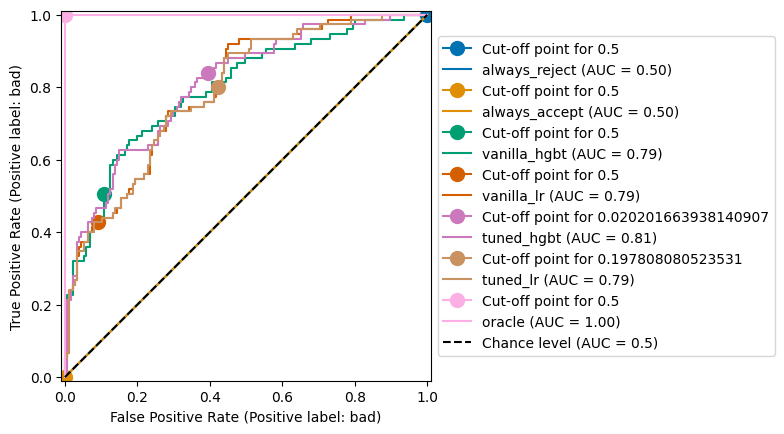

In [55]:
plot_roc_curve(results)

In our use-case, optimising the recall is of paramount importance, and our tuned cut-off point suggest a good tradeoff between recall and FPR.

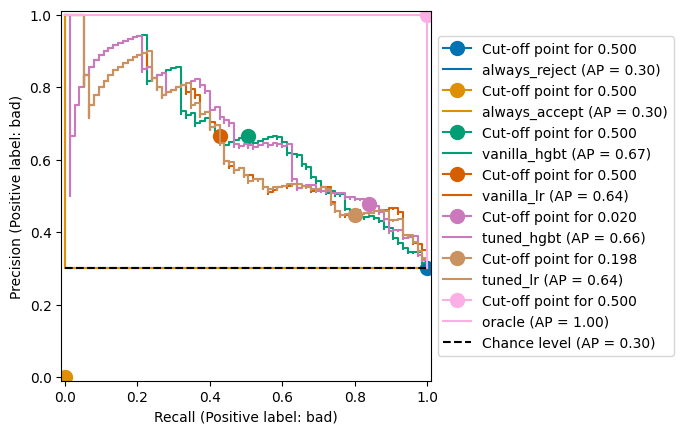

In [57]:
plot_pr_curve(results)

The same observation goes with the precision-recall curve.

Depending on the use-case, we might also consider the raw scores returned by the `predict_proba` method of our estimators. Were our estimators well calibrated, we could interprate these scores as confidence levels. 

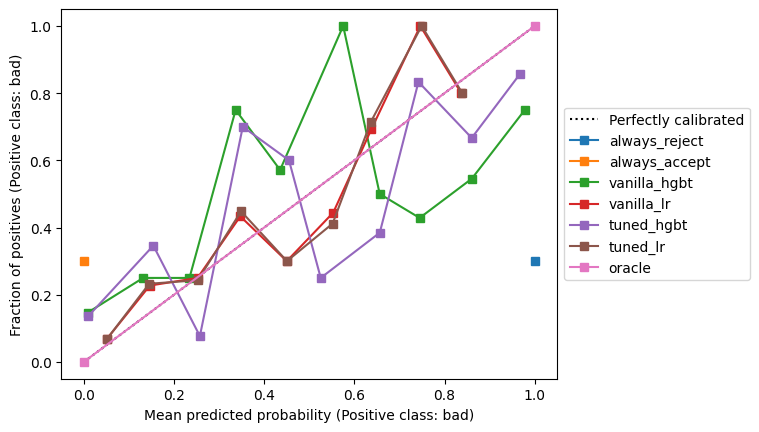

In [61]:
plot_calibration_curve(results)

On this fairly small dataset, the logistic regression is better calibrated than the trees. Also, observe the high variance of the curve between the vanilla and the tune trees. This is probably due to the small volume of data.

To give a better perspective on this calibration issue, let's plot the distributions of the predicted proba.

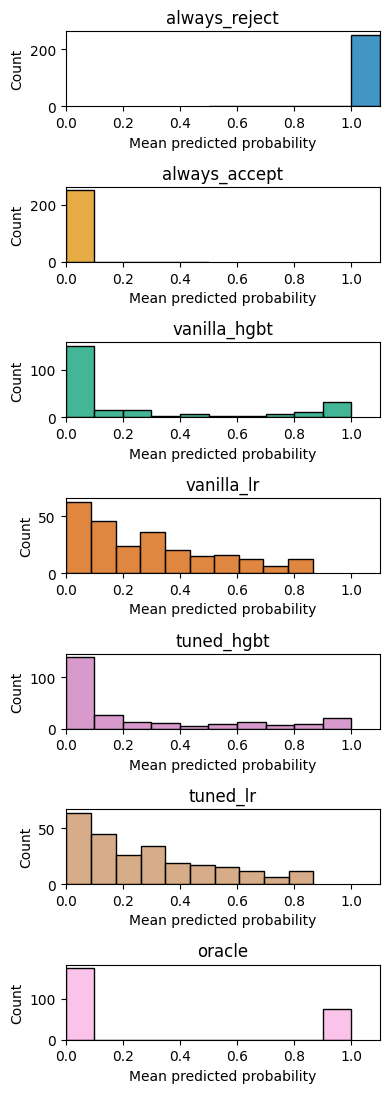

In [81]:
plot_hist_proba(results)

In conclusion:
- We beat the baselines on the utility function by a fair margin
- However, we didn't touch feature engineering, so we might win extra gain cost there
- There is room for improvement when it comes to calibration.